In [2]:
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import logging

In [ ]:

pickle_path = '../recorded-data/train/135968/snapshot.pickle'
with open(pickle_path, 'rb') as data:
        content = pickle.load(data)
        print(int(len(content.keys()) / 4))

In [1]:
import pickle
import coloredlogs, logging
import os

from torch.utils.data import Dataset
coloredlogs.install()

class IndexDataset:

    def __init__(self, dir_path):        
        self.root_path = dir_path
        self.pickle_path = os.path.join(dir_path , 'snapshot.pickle')        
        
        logging.info('Parsing pickle file...')
    
        with open(self.pickle_path, 'rb') as data:
            self.content = pickle.load(data)

        logging.info('Picklefile loaded')

        # Exclude keys that does not have a local goal [as the robot did not travel 10 meters]
        keys = list(self.content.keys())
        for key in keys:
            if 'local_goal' not in self.content[key].keys():
                self.content.pop(key)

    def __len__(self):
        # Excluding last 2 minutes of recording may not have local_goal
        # Snapshot is taken at 2 frames per second

        return int(len(self.content.keys()) / 4)
    
    def __getitem__(self, offset_index) :
        # We are taking 4 sequential images, point clouds each time to account for temporal variation
        start_index = offset_index * 4
        end_index = start_index + 3

        # Get data from respective index
        prev_cmd_vel = self.content[end_index]['prev_cmd_vel']
        gt_cmd_vel = self.content[end_index]['gt_cmd_vel']
        local_goal = self.content[end_index]['local_goal']
        robot_position = self.content[end_index]['robot_position']
        
        # Image paths
        image_paths = [ os.path.join(self.root_path, str(i)+'.jpg') for i in range(start_index, end_index+1) ]
        
        # only keep points that are under 5 + 1 (delta) meters from the robot
        point_clouds = []
        total_length = 0
        for point_snapshot in range(start_index, end_index+1):
            filtered_points = []
            grnd_pts = []
            for point in self.content[point_snapshot]['point_cloud']:
                if (point[0]**2 + point[1]**2 + point[2]**2) <= 49:
                    filtered_points.append(point)
                else:
                    grnd_pts.append(point)
            
            if len(filtered_points) < 15000:
                shortage = 15000 - len(filtered_points)
                filtered_points.extend(grnd_pts[-shortage:])

            point_clouds.append(filtered_points[0:15000])          

        return (image_paths, point_clouds, local_goal, prev_cmd_vel, robot_position, gt_cmd_vel)

        

indexer = IndexDataset('/Users/bhabaranjanpanigrahi/Research/Code/fusion-network/recorded-data/136021.bag')
# print(object.__len__())

2023-07-17 22:21:43 robotixx-s1 root[87392] INFO Parsing pickle file...


FileNotFoundError: [Errno 2] No such file or directory: '/Users/bhabaranjanpanigrahi/Research/Code/fusion-network/recorded-data/136021.bag/snapshot.pickle'

In [5]:
import torch
from torchvision import transforms
import pickle
import numpy as np
import coloredlogs, logging
import os
import cv2

from torch.utils.data import Dataset
from scipy.spatial.transform import Rotation as R

coloredlogs.install()

def read_images(path):
    # print(f"{path = }")
    image = cv2.imread(path)
    # Will have to do some re-sizing
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def get_transformation_matrix(position, quaternion):
    theta = R.from_quat([quaternion.x, quaternion.y, quaternion.z, quaternion.w]).as_euler('XYZ')[2]
    robo_coordinate_in_glob_frame  = np.array([[np.cos(theta), -np.sin(theta), position.x],
                    [np.sin(theta), np.cos(theta), position.y],
                    [0, 0, 1]])
    return robo_coordinate_in_glob_frame

def cart2polar(xyz):
    r = np.sqrt(xyz[:, 0] ** 2 + xyz[:, 1] ** 2)
    theta =  np.arctan2(xyz[:, 1], xyz[:, 0])
    return np.stack((r,theta, xyz[:,2]), axis=1)


class ApplyTransformation(Dataset):
    def __init__(self, input_data, grid_size = [72, 30, 30]):
        self.grid_size = np.asarray(grid_size)  
        self.input_data = input_data    
        self.image_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((224,224),antialias=True),
                    # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean hardcoded
                    #                       std=[0.229, 0.224, 0.225])  # ImageNet std hardcoded
            ])
    
    def __len__(self):
         # TODO: this will return 1 example set with the following details
        return len(self.input_data)

    def __getitem__(self, index):
        # Transform images
        data = self.input_data[index]
        self.image_paths = data[0]
        self.point_clouds = data[1]
        self.local_goal = data[2]
        self.prev_cmd_vel = data[3]        
        self.robot_position  = data[4]
        self.gt_cmd_vel = data[5]
        

        images = [ self.image_transforms(read_images(path)) for path in self.image_paths]
        stacked_images = torch.cat(images, dim=0)
        
        # Transform local goal into robot frame
        robot_coordinate_in_glob_frame = get_transformation_matrix(self.robot_position[0],self.robot_position[1])
        transform_to_robot_coordinate =   np.linalg.pinv(robot_coordinate_in_glob_frame)

        local_goal_in_robot_frame = transform_to_robot_coordinate @ np.asanyarray([self.local_goal[0], self.local_goal[1],1]).reshape((3,1))	
        local_goal = (local_goal_in_robot_frame[0,0], local_goal_in_robot_frame[1,0])

        # Transform point-clouds to 3D-Cylider co-ordinate system
        point_clouds = np.concatenate(self.point_clouds, axis=0)   

        # TODO: subsample the point clouds to keep a fixed number of points across frames
        xyz_polar = cart2polar(point_clouds)

        max_bound_r = np.percentile(xyz_polar[:, 0], 100, axis=0)
        min_bound_r = np.percentile(xyz_polar[:, 0], 0, axis=0)

        max_bound = np.max(xyz_polar[:, 1:], axis=0)
        min_bound = np.min(xyz_polar[:, 1:], axis=0)

        max_bound = np.concatenate(([max_bound_r],max_bound))
        min_bound = np.concatenate(([min_bound_r], min_bound))

        range_to_crop = max_bound - min_bound
        cur_grid_size = (self.grid_size - 1)
        intervals = range_to_crop / cur_grid_size

        if (intervals == 0).any(): print("Zero interval!")
        grid_index = (np.floor(( np.clip(xyz_polar, min_bound, max_bound) - min_bound) / intervals)).astype(int)
        
        # Center data around each voxel for PTnet
        voxel_centers = (grid_index.astype(np.float32) + 0.5) * intervals + min_bound
        return_xyz = xyz_polar - voxel_centers
        transformed_pcl = np.concatenate((return_xyz, xyz_polar, point_clouds[:, :2]), axis=1)

         

        local_goal = torch.tensor(local_goal, dtype=torch.float32).ravel()
        local_goal = (local_goal - local_goal.min()) / (local_goal.max() - local_goal.min())

        prev_cmd_vel = torch.tensor(self.prev_cmd_vel, dtype=torch.float32).ravel()
        gt_cmd_vel = torch.tensor(self.gt_cmd_vel, dtype=torch.float32).ravel()


        return (stacked_images, torch.tensor(grid_index), torch.tensor(transformed_pcl), local_goal, prev_cmd_vel, gt_cmd_vel)

In [6]:
data = next(iter(ApplyTransformation(indexer)))
print(f"{data[2].shape = }")

NameError: name 'indexer' is not defined

In [90]:
x[2].shape

torch.Size([29269, 8])

In [38]:
y = x[1][1]
c = []
c.append(y)
c.append(y)
c.append(y)
d = torch.tensor(c)

In [39]:
d.shape

torch.Size([3, 29269, 8])

In [40]:
x = [torch.from_numpy(i) for i in c]

In [52]:
l = x[0]

In [56]:
l.shape

torch.Size([29269, 8])

In [51]:
import torch.nn.functional as F
d = np.ones((100,8))


In [57]:

k = F.pad(l, (1, 0), 'constant', value=7)

In [60]:
k[0]

tensor([ 7.0000e+00,  9.1713e-03,  8.8107e-03, -3.8865e-03,  3.0948e+00,
        -1.7204e+00, -8.2926e-01, -4.6118e-01, -3.0603e+00],
       dtype=torch.float64)

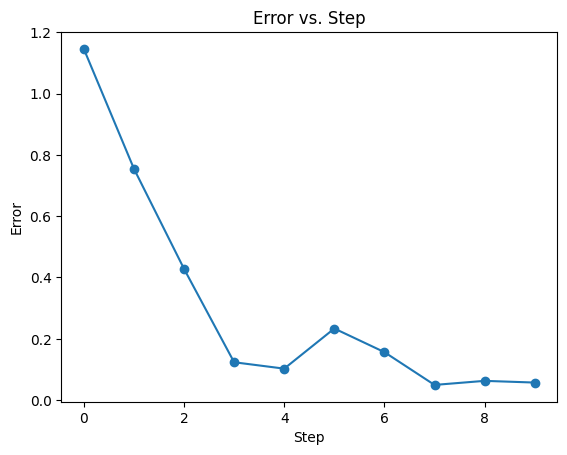

In [14]:
import matplotlib.pyplot as plt

# Create x and y data
x = [i for i in range(10)]
y = [1.1454883813858032, 0.7548354268074036, 0.42827606201171875, 0.12355022132396698, 0.10271172225475311, 0.23359526693820953, 0.15651413798332214, 0.049618806689977646, 0.06286948174238205, 0.057311490178108215]

# Plot the graph
plt.plot(x, y, '-o')
plt.xlabel('Step')
plt.ylabel('Error')
plt.title('Error vs. Step')
plt.show()

In [2]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import tf
import torch
from torch.utils.data import Dataset
import pickle
import coloredlogs, logging
import os

from torch.utils.data import Dataset
coloredlogs.install()


ModuleNotFoundError: No module named 'scipy'

In [46]:
class IndexDataset(Dataset):

    def __init__(self, dir_path):        
        self.root_path = dir_path
        self.pickle_path = os.path.join(dir_path , 'snapshot.pickle')        
        
        logging.info(f'Parsing pickle file: {self.pickle_path}')
    
        with open(self.pickle_path, 'rb') as data:
            self.content = pickle.load(data)

        logging.info('Picklefile loaded')

        # Exclude keys that does not have a local goal [as the robot did not travel 10 meters]
        keys = list(self.content.keys())
        for key in keys:
            if len(self.content[key]['local_goal'])!=12:                
                print(key)
                self.content.pop(key)

    def __len__(self):
        # As images and point clouds will be in sets of 4
        return int(len(self.content.keys()) - 4)
    
    def __getitem__(self, offset_index) :
        # We are taking 4 sequential images, point clouds each time to account for temporal variation
        start_index = offset_index

        # Get data from respective index       
        gt_cmd_vel = self.content[start_index]['gt_cmd_vel']
        local_goal = self.content[start_index]['local_goal']
        robot_position = self.content[start_index]['robot_position']
        
        # Image paths
        image_paths = [ os.path.join(self.root_path, str(i)+'.jpg') for i in range(start_index, start_index+1) ]
        
        # only keep points that are under 5 + 1 (delta) meters from the robot
        point_clouds = []
        # print(list(self.content.keys()), start_index, end_index)
        for point_snapshot in range(start_index, start_index+1):
            filtered_points = []            
            for point in self.content[point_snapshot]['point_cloud']:
                if point[0] >= -1 and point[0] <= 5 and point[1]>=-3 and point[1]<=3 and point[2] >= 0.0299 and point[2] <= 6.0299:
                    filtered_points.append(point)                           

            point_clouds.append(filtered_points)                

        return (image_paths, point_clouds, local_goal, robot_position, gt_cmd_vel)

In [158]:
idxer = IndexDataset('/home/ranjan/Workspace/my_works/fusion-network/recorded-data/train/135968_wt_at')

2023-08-02 20:33:33 robotixx-s1 root[92716] INFO Parsing pickle file: /home/ranjan/Workspace/my_works/fusion-network/recorded-data/train/135968_wt_at/snapshot.pickle
2023-08-02 20:33:54 robotixx-s1 root[92716] INFO Picklefile loaded


2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724


In [159]:
keys = list(idxer.content.keys())
anglr_vel = []
for key in keys:
    anglr_vel.append(idxer.content[key]['gt_cmd_vel'][2])

anglr_vel = np.array(anglr_vel)

In [160]:
anglr_vel.shape

(2683,)

In [161]:
import numpy as np
import matplotlib.pyplot as plt

def plot_bucket_histogram(data_array, num_buckets=10):
    # Ensure the input data is a NumPy array
    data_array = np.array(data_array)
    
    # Validate the number of buckets parameter
    if not isinstance(num_buckets, int) or num_buckets <= 0:
        raise ValueError("Number of buckets should be a positive integer.")
    
    # Calculate the range of values in the data array
    min_value = np.min(data_array)
    max_value = np.max(data_array)
    
    # If the min_value and max_value are the same, handle the edge case
    if min_value == max_value:
        bucket_size = 1
        bucket_limits = [min_value, max_value]
    else:
        # Calculate the size of each bucket
        bucket_size = (max_value - min_value) / num_buckets
    
        # Create an array of bucket limits
        bucket_limits = [min_value + i * bucket_size for i in range(num_buckets)]
        bucket_limits.append(max_value)  # Include the upper limit of the last bucket
    
    # Initialize an empty dictionary to store the number of elements in each bucket
    bucket_counts = {i: 0 for i in range(num_buckets)}
    
    # Iterate through the data array and count elements in each bucket
    for value in data_array:
        # Ensure the bucket_idx is within the valid range
        bucket_idx = int((value - min_value) / bucket_size)
        bucket_idx = max(0, min(bucket_idx, num_buckets - 1))
        bucket_counts[bucket_idx] += 1
    
    # Extract the counts and bucket limits for plotting
    counts = list(bucket_counts.values())
    limits = list(bucket_limits)
    
    # Plot the histogram
    plt.bar(limits[:-1], counts, width=bucket_size, align='edge')
    plt.xlabel("Bucket")
    plt.ylabel("Number of Elements")
    plt.title("Histogram of Buckets vs. Number of Elements")
    plt.grid(True)
    plt.show()

# Test the function with a sample data array containing floating-point numbers
# np.random.seed(42)
# sample_data = np.random.uniform(0, 100, size=1000)
# plot_bucket_histogram(sample_data, num_buckets=10)


In [162]:
anglr_vel.shape

(2683,)

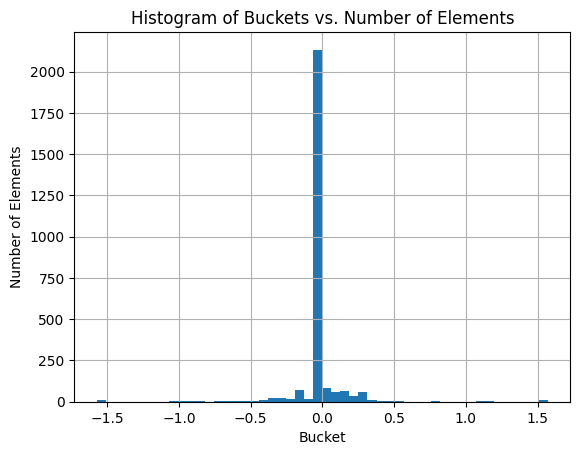

In [163]:
plot_bucket_histogram(anglr_vel,50)

In [169]:
def scale_min_max(x,min_val=0, max_val=6):    
    x = np.interp(x,(-0.55, 0.55), (0, 20000))
    return x

In [170]:
def reverse_scale_min_max(x,min_val=0, max_val=6):    
    x = np.interp(x,(0, 20000), (-0.55, 0.55))
    return x

In [174]:
p = scale_min_max(-0.01 )
print(f'scaled: {p}')

scaled: 9818.181818181818


In [175]:
p = reverse_scale_min_max(p)
print(f'reverse scaled: {p}')

reverse scaled: -0.010000000000000009


In [45]:

def get_transformation_matrix(position, quaternion):
    theta = R.from_quat(quaternion).as_euler('XYZ')[2]
    robo_coordinate_in_glob_frame  = np.array([[np.cos(theta), -np.sin(theta), position[0]],
                    [np.sin(theta), np.cos(theta), position[1]],
                    [0, 0, 1]])
    return robo_coordinate_in_glob_frame

def get_transformation_matrix_tf(position, quaternion):
    
    q = tf.transformations.quaternion_from_euler(quaternion[0], quaternion[1], quaternion[2])
    rotation_matrix = tf.transformations.quaternion_matrix(q)
    translation = -np.matmul(rotation_matrix, np.array([position[0],position[1],0,1]).reshape(4,1))
    translation[3,0]=1
    # print(tr)
    transformation_matrix = np.concatenate([rotation_matrix[:,:3], translation], axis=1)
    
    return transformation_matrix


def quaternion_to_rotation_matrix(position,q):
    # Normalize the quaternion to ensure it's a unit quaternion
    qx, qy, qz, qw = q
    magnitude = np.sqrt(qx**2 + qy**2 + qz**2 + qw**2)
    qx /= magnitude
    qy /= magnitude
    qz /= magnitude
    qw /= magnitude

    # Compute the rotation matrix from the normalized quaternion
    rotation_matrix = np.array([[1 - 2*qy**2 - 2*qz**2, 2*qx*qy - 2*qz*qw, 2*qx*qz + 2*qy*qw],
                                [2*qx*qy + 2*qz*qw, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz - 2*qx*qw],
                                [2*qx*qz - 2*qy*qw, 2*qy*qz + 2*qx*qw, 1 - 2*qx**2 - 2*qy**2]])
    
    translation = -np.matmul(rotation_matrix, np.array([position[0],position[1],0]).reshape(3,1))
    transformation_matrix = np.concatenate([rotation_matrix[:,:3], translation], axis=1)

    return transformation_matrix

In [53]:
x = idxer.__getitem__(420)


In [54]:
print(x[4][0])
print(x[4][1])

0.8579392997585997
0.0


In [55]:
x[2]

[(621.2655158795263, -16.81702351642675),
 (620.7671381178258, -16.747722991326775),
 (620.2909399974401, -16.692712400240076),
 (619.7569130791198, -16.631103666121977),
 (619.2413009377151, -16.600038046079177),
 (618.7200740628001, -16.52289582791648),
 (618.2712885782366, -16.32064604050052),
 (617.8444107547102, -16.04634388675987),
 (617.5198434599708, -15.660985181540298),
 (617.2458742384703, -15.251861836295433),
 (616.8781886850026, -14.89519274927153),
 (616.5340518578414, -14.556603858332863)]

In [56]:
matrix = get_transformation_matrix(x[3][0],x[3][1])
matrix_inv = np.linalg.pinv(matrix)

In [57]:
goals = np.array(x[2])
goals = np.concatenate([x[2], np.ones((12,1))], axis=1).transpose()
goals

array([[621.26551588, 620.76713812, 620.29094   , 619.75691308,
        619.24130094, 618.72007406, 618.27128858, 617.84441075,
        617.51984346, 617.24587424, 616.87818869, 616.53405186],
       [-16.81702352, -16.74772299, -16.6927124 , -16.63110367,
        -16.60003805, -16.52289583, -16.32064604, -16.04634389,
        -15.66098518, -15.25186184, -14.89519275, -14.55660386],
       [  1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ,   1.        ,   1.        ]])

In [58]:
# np.matmul(matrix2, np.array([x[2][0],x[2][1],0,1]).reshape(4,1))
l = np.matmul(matrix_inv, goals)

In [59]:
l

array([[ 0.62019559,  1.11985928,  1.59444499,  2.12664282,  2.63328369,
         3.15703808,  3.64243784,  4.12491392,  4.53657972,  4.90532603,
         5.35142724,  5.77016513],
       [ 0.01537116,  0.07469361,  0.14221565,  0.21801704,  0.31869467,
         0.37622481,  0.2943685 ,  0.13725968, -0.1532167 , -0.47950983,
        -0.73130184, -0.97157496],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ]])

In [60]:
for i in range(0,11):
    p = np.array(l[:2,i])
    q = np.array(l[:2,i+1])

    # print(f'point a:{p}')
    # print(f'point b:{q}')

    print(np.sum(np.square(p - q)))

0.25318295613663816
0.22979081499066828
0.28898038561012906
0.2668209531126945
0.2776283769567399
0.24231338766468258
0.257466347765378
0.2538452605029833
0.24244104595397198
0.26240550386726613
0.23307259287565116


In [61]:
x[4]

(0.8579392997585997, 0.0, 0.298080747048154)

In [194]:
lc

array([ 78.20655317, 520.16068846])

In [195]:

coordinates =np.expand_dims( np.concatenate([lc, [0], [1] ], axis=0), axis=1)

In [196]:
coordinates

array([[ 78.20655317],
       [520.16068846],
       [  0.        ],
       [  1.        ]])

In [197]:
print(matrix.shape)
print(coordinates.shape)

(4, 4)
(4, 1)


In [198]:
l = np.matmul(matrix, coordinates)

In [233]:
l

array([[-2.96944330e+00],
       [-6.31978288e-01],
       [-2.75284144e-03],
       [ 1.00000000e+00]])

In [188]:
p = np.array(l[:2,0])
q = np.array(l[:2,1])

print(f'point a:{p}')
print(f'point b:{q}')

print(np.sum(np.square(p - q)))

IndexError: index 1 is out of bounds for axis 1 with size 1

In [234]:
tf_matrix = get_transformation_matrix_tf(x[4][0],x[4][1])

In [235]:
tf_matrix

array([[ 6.67854840e-01,  7.44287495e-01, -2.45729141e-03,
        -4.42349164e+02],
       [-7.44258702e-01,  6.67852742e-01,  7.19016087e-03,
        -2.89816813e+02],
       [ 6.99265563e-03, -2.97312322e-03,  9.99971131e-01,
         9.96877483e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [236]:
lcg = np.matmul(tf_matrix, np.array([x[2][0],x[2][1],0,1]).reshape(4,1))

In [237]:
lcg

array([[-2.96944330e+00],
       [-6.31978288e-01],
       [-2.75284144e-03],
       [ 1.00000000e+00]])

In [238]:
x[5]

(1.6, -0.2383513041904995, -0.0)

In [239]:
import numpy as np
p = np.array(y[3])

NameError: name 'y' is not defined

In [240]:
p.shape

(2,)

In [16]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(p)

In [17]:
o3d.visualization.draw_geometries([pcd])

In [19]:
from open3d import JVisualizer

ImportError: cannot import name 'JVisualizer' from 'open3d' (/home/ranjan/anaconda3/envs/mlp/lib/python3.10/site-packages/open3d/__init__.py)

In [58]:
y[1,:,2]

array([0.2442262 , 0.31631052, 0.39115849, ..., 0.36959362, 0.10310185,
       0.17326561])

In [1]:
x

NameError: name 'x' is not defined

In [63]:
import numpy as np
import torch
import torch.nn as nn


def scale_min_max(points,min_val=0, max_val=6):    

    x = np.expand_dims(np.array(points[:,0]), axis=1)    
    y = np.expand_dims(np.array(points[:,1]), axis=1)
    z = np.expand_dims(np.array(points[:,2]), axis=1)

    x = np.interp(x,(-1, 5), (min_val, max_val))
    y = np.interp(y,(-3, 3), (min_val, max_val))

    return np.concatenate([x,y,z], axis=1)



def get_voxelized_points(points_array):
    # Define the grid dimensions
    grid_size = 122  # Adjust based on your requirements

    # Create an empty voxel grid
    voxel_grid = np.zeros((142, grid_size, 42))    

    # Calculate the voxel size based on the grid dimensions
    voxel_size = 0.05

    if points_array.shape[0] == 0:
        input_tensor = torch.tensor(voxel_grid, dtype=torch.float32)
        input_tensor = input_tensor.unsqueeze(0)
        # print(f'returned_zeroed_array {input_tensor.shape}')
        return input_tensor

    # scale coordinate value
    points_array = scale_min_max(points_array)
    

    # Map points to the voxel grid
    grid_indices = np.floor(points_array / voxel_size).astype(int)
    grid_indices = np.clip(grid_indices, 0, grid_size - 1)

    unique_indices, counts = np.unique(grid_indices, return_counts=True, axis=0)

    voxel_grid[unique_indices[:, 0], unique_indices[:, 1], unique_indices[:, 2]] = counts

    # Convert the voxel grid to a PyTorch tensor
    input_tensor = torch.tensor(voxel_grid, dtype=torch.float32)
    input_tensor = input_tensor.unsqueeze(0)  # Add batch and channel dimensions

    return input_tensor

In [13]:
x.shape

(2000, 3)

In [14]:
x[0]

array([0.61073304, 0.65121455, 0.47544591])

In [102]:
import numpy as np
import torch
import torch.nn as nn

def scale_min_max(points,min_val=0, max_val=6):    

    x = np.expand_dims(np.array(points[:,0]), axis=1)    
    y = np.expand_dims(np.array(points[:,1]), axis=1)
    z = np.expand_dims(np.array(points[:,2]), axis=1)

    x = np.interp(x,(-7, 8), (min_val, 8))
    y = np.interp(y,(-3, 3), (min_val, max_val))

    return np.concatenate([x,y,z], axis=1)



def get_voxelized_points(points_array):

    print(np.max(points_array, axis=0))
    # Define the grid dimensions
    grid_size = 122  # Adjust based on your requirements

    # Calculate the voxel size based on the grid dimensions
    voxel_size = 0.05

    # scale coordinate value
    points_array = scale_min_max(points_array)
    print(np.max(points_array, axis=0))
    # Create an empty voxel grid
    voxel_grid = np.zeros((162, grid_size, 42))

    # Map points to the voxel grid
    grid_indices = np.floor(points_array / voxel_size).astype(int)
    
    print(np.max(grid_indices, axis=0))

    grid_indices = np.clip(grid_indices, np.array([0,0,0]), np.array([161,121,41]))

    print(np.max(grid_indices, axis=0))

    voxel_grid[grid_indices[:, 0], grid_indices[:, 1], grid_indices[:, 2]] = voxel_grid[grid_indices[:, 0], grid_indices[:, 1], grid_indices[:, 2]] + 1

    # Convert the voxel grid to a PyTorch tensor
    input_tensor = torch.tensor(voxel_grid, dtype=torch.float32)
    input_tensor = input_tensor.unsqueeze(0)  # Add batch and channel dimensions

    return input_tensor 

In [104]:
pts = np.random.randint(size=(100,3), low=0, high=9)
voxelized_points = get_voxelized_points(pts)

[8 8 8]
[8. 6. 8.]
[160 120 160]
[160 120  41]


In [69]:
voxelized_points.shape

torch.Size([1, 142, 122, 42])

In [23]:
 
common = nn.Sequential(
    nn.Conv3d(in_channels=1, out_channels=8, kernel_size=3, stride=1),
    nn.LeakyReLU(),
    nn.Conv3d(in_channels=8, out_channels=12, kernel_size=3, stride=1),
    nn.LeakyReLU(),   
    nn.MaxPool3d(3, stride=2)                   
    )

ft1 = nn.Sequential(
    nn.Conv3d(in_channels=12, out_channels=16, kernel_size=3, stride=1),
    nn.LeakyReLU(),
    nn.MaxPool3d(3, stride=2)
)

ft2 = nn.Sequential(
    nn.Conv3d(in_channels=16, out_channels=32, kernel_size=5, stride=1),
    nn.LeakyReLU(),
    nn.MaxPool3d(3, stride=2)
)

ft3 = nn.Sequential(
    nn.Conv3d(in_channels=32, out_channels=48, kernel_size=1, stride=1),
    nn.LeakyReLU(),    
)   

In [24]:
x = np.random.rand(2000, 3)
x = get_voxelized_points(x)
x = common(x)
x.shape

torch.Size([2, 27, 27, 27])

In [25]:
x = ft1(x)
x.shape

torch.Size([2, 12, 12, 12])

In [26]:
x = ft2(x)
x.shape

torch.Size([4, 10, 10, 10])

In [151]:
x= ft3(x)
x.shape

torch.Size([48, 11, 11, 11])

In [217]:
def get_gaussian_weights(mean, std_dev):

    domain = np.array([i for i in range(0,12)])

    range_values = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((domain - mean) / std_dev)**2)
    
    round_weights = np.floor(range_values*1000) + 100
    reshapeed_weights  = np.expand_dims(round_weights, axis=0)
    
    return  reshapeed_weights

Value at x = 0 is 0.02590351913317835
Value at x = 1 is 0.03427371840956147
Value at x = 2 is 0.043570435406510115
Value at x = 3 is 0.05321704997975097
Value at x = 4 is 0.06245078667335226
Value at x = 5 is 0.0704130653528599
Value at x = 6 is 0.07627756309210483
Value at x = 7 is 0.07939050949540237
Value at x = 8 is 0.07939050949540237
Value at x = 9 is 0.07627756309210483
Value at x = 10 is 0.0704130653528599
Value at x = 11 is 0.06245078667335226
Value at x = 12 is 0.05321704997975097


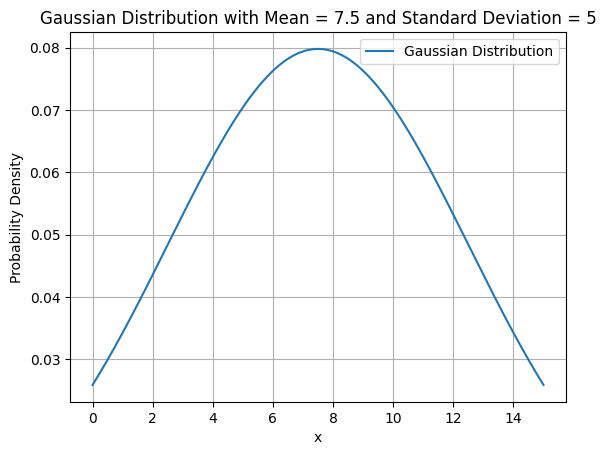

In [224]:
import numpy as np
import matplotlib.pyplot as plt

# Define the mean and standard deviation of the Gaussian distribution
mean = 7.5
std_dev = 5

# Generate data points for x-axis (higher resolution)
x = np.linspace(0, 15, 1000)
y = np.array([i for i in range(0,13)])

# Calculate the corresponding probabilities for each data point (PDF)
pdf = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)
pdf2 = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((y - mean) / std_dev)**2)
# Output the values at integer points

for i in range(len(y)):    
    print("Value at x =", i, "is", pdf2[i])

# Plot the Gaussian distribution
plt.plot(x, pdf, label='Gaussian Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution with Mean = {} and Standard Deviation = {}'.format(mean, std_dev))
plt.legend()
plt.grid(True)
plt.show()


In [225]:
rv = get_gaussian_weights(7.5,5)

In [226]:
x = np.ones((3,12))

In [227]:
x 

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [228]:
rv.shape

(1, 12)

In [229]:
x * rv

array([[125., 134., 143., 153., 162., 170., 176., 179., 179., 176., 170.,
        162.],
       [125., 134., 143., 153., 162., 170., 176., 179., 179., 176., 170.,
        162.],
       [125., 134., 143., 153., 162., 170., 176., 179., 179., 176., 170.,
        162.]])

In [230]:
x * rv

array([[125., 134., 143., 153., 162., 170., 176., 179., 179., 176., 170.,
        162.],
       [125., 134., 143., 153., 162., 170., 176., 179., 179., 176., 170.,
        162.],
       [125., 134., 143., 153., 162., 170., 176., 179., 179., 176., 170.,
        162.]])